In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [11]:
data_location = "E:/Project 6 - Temperature/Experiments/data_analysis/"

dates = [
    "10-28-22", "11-04-22", "03-29-24",
    "08-09-24", "08-23-24", "08-16-24",
    "09-20-24",
    # "03-29-24", "08-09-24", "08-23-24",
]
positions = [
    (0, 12), (0, 12), (0, 13),
    (0, 13), (0, 13), (0, 13),
    (0, 13),
    # (14, 27), (14, 27), (14, 27),
]

conditions = [
    "Control", "Control", "Control",
    "Control", "Control", "Control",
    "Control",
    # "+10ng/uL CycB mRNA", "+20ng/uL CycB mRNA", "+4uM MO",
]

colors = [
    "tab:blue", "tab:orange", "tab:green",
    "tab:red", "tab:purple", "tab:brown",
    "tab:olive",
    # "tab:green", "tab:red", "tab:purple",
]

line_styles = [
    "-", "-", "-",
    "-", "-", "-",
    "-",
    # "--", "--", "--",
]

marker_styles = [
    "o", "o", "o",
    "o", "o", "o",
    "o",
    # "x", "x", "x",
]

cycle_to_plot = [
    1, 1, 1, 
    2, 2, 1,
    2,
    # 1, 2, 2,
]

cycle_calculation = [
    "TROUGH_TO_TROUGH", "TROUGH_TO_TROUGH", "TROUGH_TO_TROUGH",
    "TROUGH_TO_TROUGH", "TROUGH_TO_TROUGH", "TROUGH_TO_TROUGH",
    "TROUGH_TO_TROUGH",
    # "TROUGH_TO_TROUGH", "TROUGH_TO_TROUGH", "TROUGH_TO_TROUGH",
]

pguess = [
    (10.0, 0.3, 30.0, 10.0, 0.5, 17.0, 100.0),
    (0.5, 1.5, 25.0, 9.0, 1.7, 19.2, 114.0),
    (1.0, 1.4, 25.0, 6.4, 1.3, 17.0, 65.0),
    (10.0, 0.9, 27.0, 10.0, 0.7, 17.0, 70.0),
    (0.3, 1.9, 30.0, 3.5, 0.9, 16.4, 57.8),
    (0.3, 1.9, 30.0, 3.5, 0.9, 16.4, 57.8), # check
    (10.0, 0.3, 30.0, 10.0, 0.5, 17.0, 100.0),
    # (0.3, 1.9, 30.0, 3.5, 0.9, 16.4, 57.8),
    # (10.0, 0.9, 27.0, 10.0, 0.7, 17.0, 70.0),
    # (10.0, 0.9, 27.0, 10.0, 0.7, 17.0, 70.0),
]

xenopus_preferred_temp_range = (20, 25)

np.random.seed(1)

# Raster plots

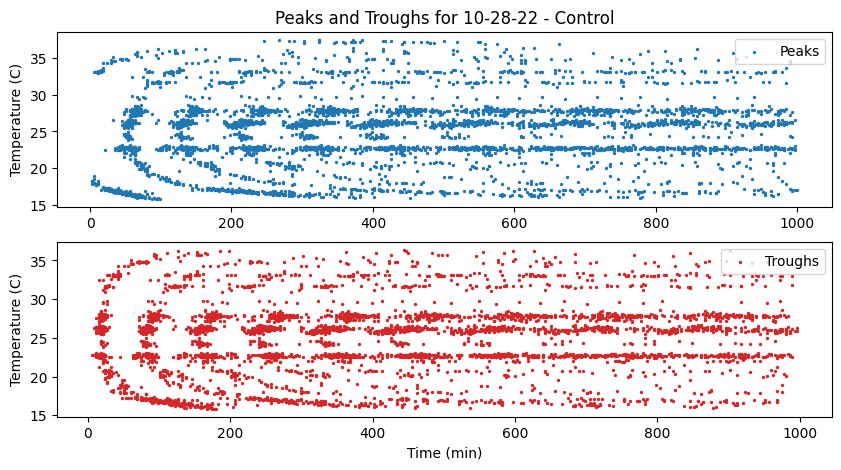

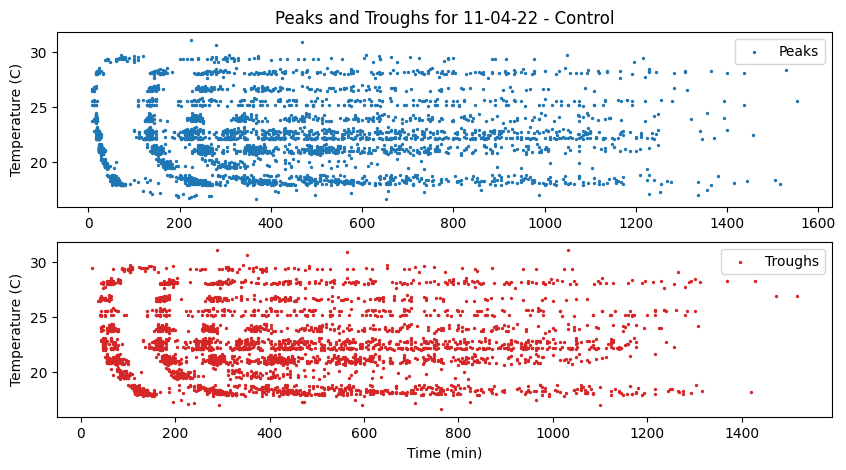

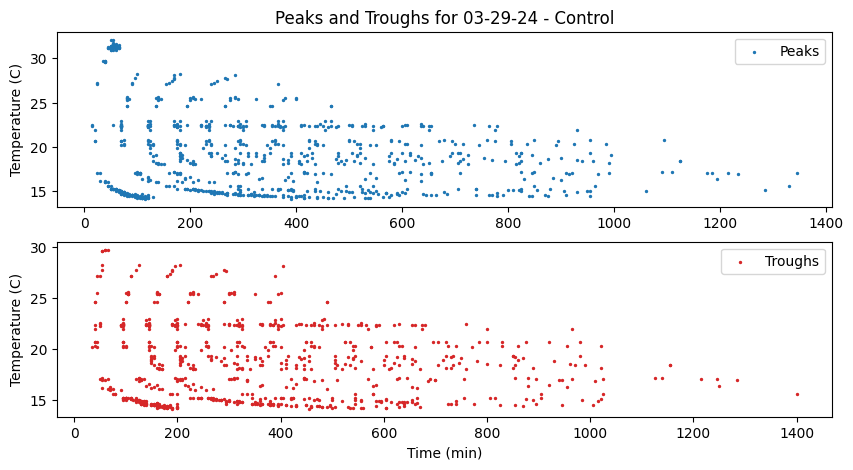

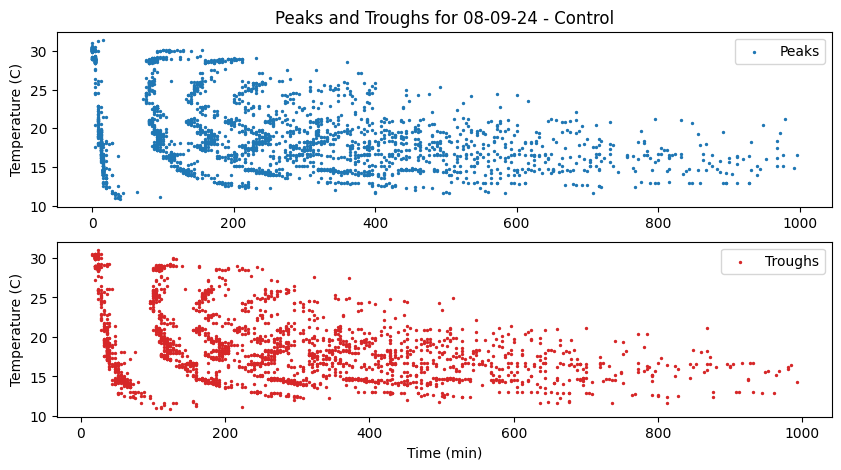

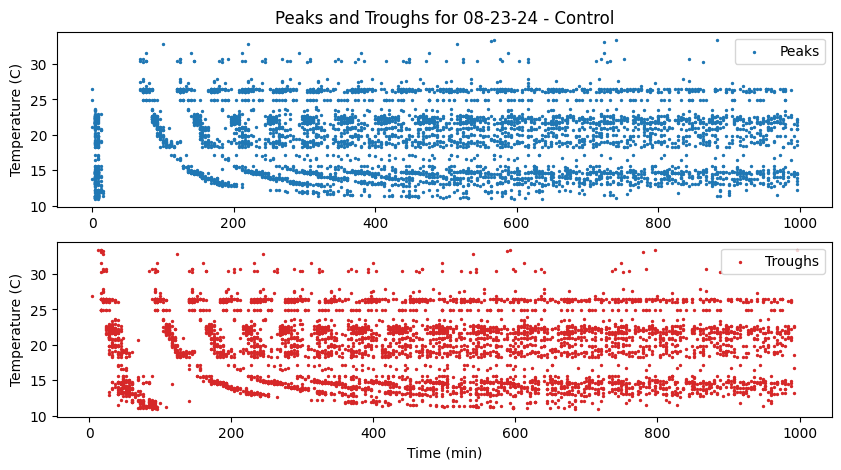

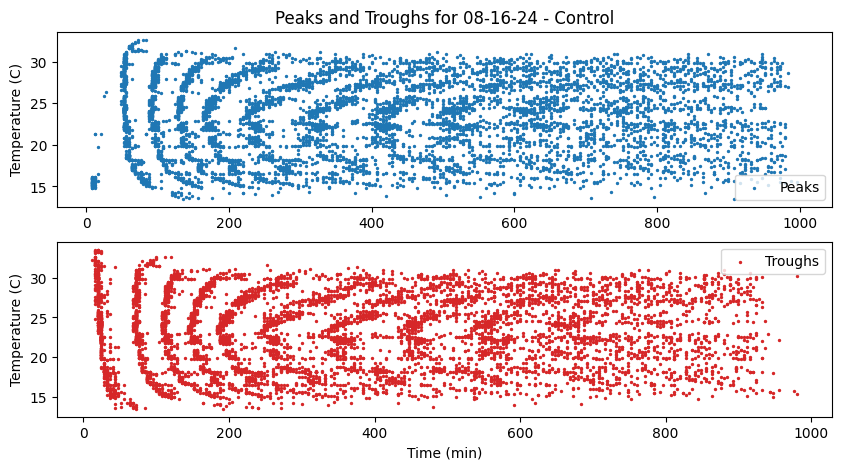

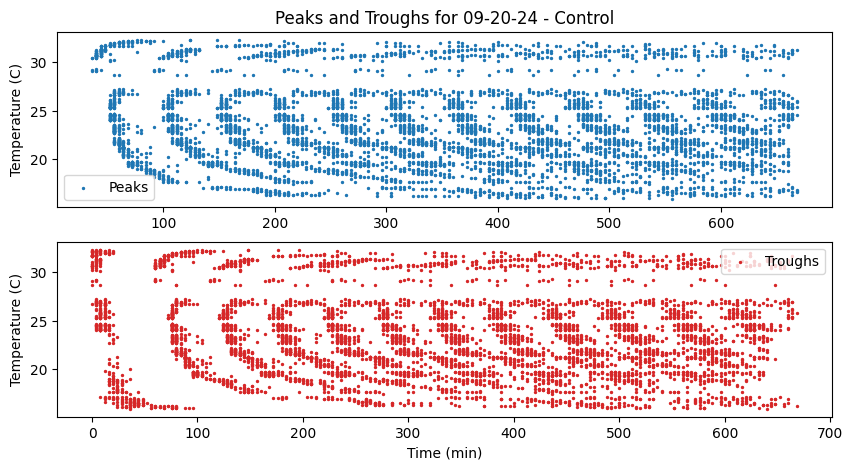

In [12]:
scatter_marker_size = 2

for idx, date in enumerate(dates):
    features_file_location = os.path.join(data_location, date, 
                                          f"{date}_all_features_combined_renumbered.csv")
    all_features = pd.read_csv(features_file_location)
    position_selection = (all_features["POSITION"] >= positions[idx][0]) & \
                         (all_features["POSITION"] <= positions[idx][1])
    condition = conditions[idx]
    peak_selection = (all_features["TYPE"] == "PEAK")
    trough_selection = (all_features["TYPE"] == "TROUGH")
    fig, ax = plt.subplots(2, 1, figsize=(10, 5))
    # Peaks
    peak_data = all_features[position_selection & peak_selection]
    ax[0].scatter(peak_data["TIME"], peak_data["MEAN_TEMPERATURE"], c="tab:blue", label="Peaks",
                  s=scatter_marker_size)
    # Troughs
    trough_data = all_features[position_selection & trough_selection]
    ax[1].scatter(trough_data["TIME"], trough_data["MEAN_TEMPERATURE"], c="tab:red", label="Troughs",
                  s=scatter_marker_size)
    ax[0].set_title(f"Peaks and Troughs for {date} - {condition}")
    ax[1].set_xlabel("Time (min)")
    ax[0].set_ylabel("Temperature (C)")
    ax[1].set_ylabel("Temperature (C)")
    ax[0].legend()
    ax[1].legend()
    plt.show()

# Periods

In [9]:
def fitting_fn(x, a, b, c, d, e, f, g):
    rising_exp = a * np.exp(b * (x - c))
    falling_exp = d * np.exp(-e * (x - f))
    return rising_exp + falling_exp + g


def fit_period_curve(x, y, p_guess, xfit_points=1000):
    # sort by x for reproducibility
    sort_idx = np.argsort(x)
    x = x[sort_idx]
    y = y[sort_idx]
    popt, pcov = curve_fit(fitting_fn, x, y, p0=p_guess)
    xfit = np.linspace(x.min(), x.max(), xfit_points)
    yfit = fitting_fn(xfit, *popt)
    return xfit, yfit, popt

# Create CSV output

In [81]:
# Create CSV to share
output_df = pd.DataFrame()
# Individual fits

for idx, date in enumerate(dates):
    period_file_location = os.path.join(data_location, date, f"{date}_full_periods.csv")
    full_periods = pd.read_csv(period_file_location)
    position_selection = (full_periods["POSITION"] >= positions[idx][0]) & \
                         (full_periods["POSITION"] <= positions[idx][1])
    cycle_selection = (full_periods[f"{cycle_calculation[idx]}_CYCLE_NUMBER"] == cycle_to_plot[idx])
    control_periods = full_periods[position_selection & cycle_selection]
    condition = conditions[idx]
    x = control_periods["MEAN_TEMPERATURE"].values
    y = control_periods[f"{cycle_calculation[idx]}_PERIOD"].values

    # Since I haven't fully curated 08-16-24 yet, I'll remove outliers manually here
    if date == "08-16-24":
        temp_range = (x > 17.0)
        period_range = (y > 125.0)
        selection = temp_range & period_range
        x = x[~selection]
        y = y[~selection]


    sub_df = pd.DataFrame({
        "Temperature": x,
        "Period": y,
        "Date": date,
        "Condition": condition,
    })
    output_df = pd.concat([output_df, sub_df])

print(output_df)

output_df.to_csv("E:/Project 6 - Temperature/Experiments/data_analysis/period_comparison_all_data.csv", index=False)

     Temperature  Period      Date Condition
0      16.685455   174.0  10-28-22   Control
1      16.827161   162.0  10-28-22   Control
2      16.327402   240.0  10-28-22   Control
3      17.026198   153.0  10-28-22   Control
4      16.652245   174.0  10-28-22   Control
..           ...     ...       ...       ...
285    13.990201   260.0  08-23-24   +4uM MO
286    12.973412   492.0  08-23-24   +4uM MO
287    13.446414   296.0  08-23-24   +4uM MO
288    13.075561   460.0  08-23-24   +4uM MO
289    12.924375   472.0  08-23-24   +4uM MO

[3803 rows x 4 columns]


# Individual fits

Processing 10-28-22


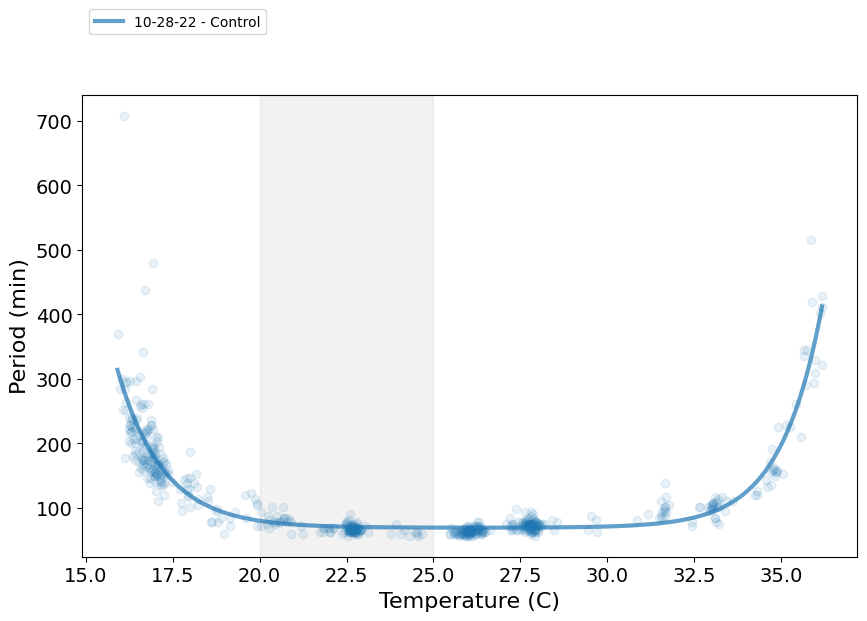

Processing 11-04-22


C:\Users\tavel\AppData\Local\Temp\ipykernel_19780\3246042356.py:3: RuntimeWarning: overflow encountered in exp
  falling_exp = d * np.exp(-e * (x - f))


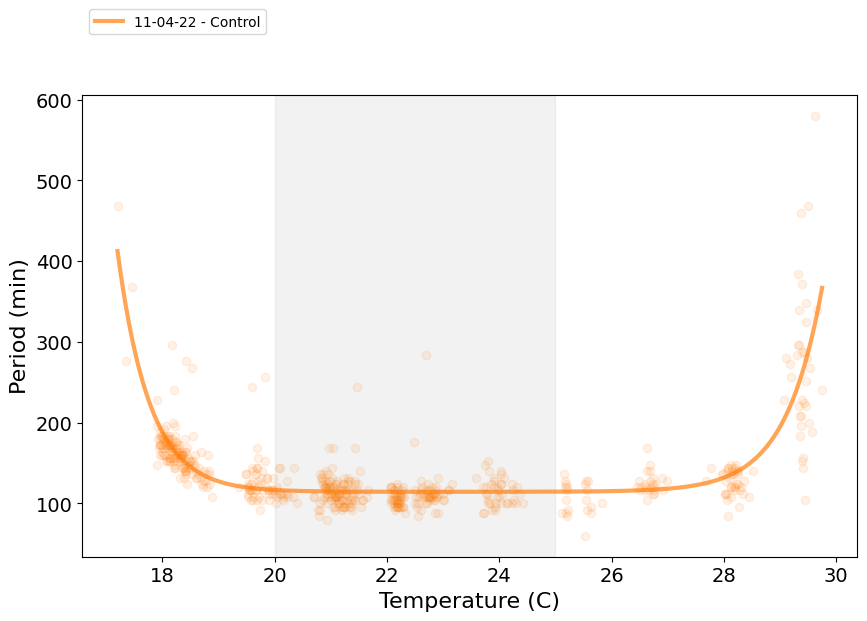

Processing 03-29-24


C:\Users\tavel\AppData\Local\Temp\ipykernel_19780\3246042356.py:12: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(fitting_fn, x, y, p0=p_guess)


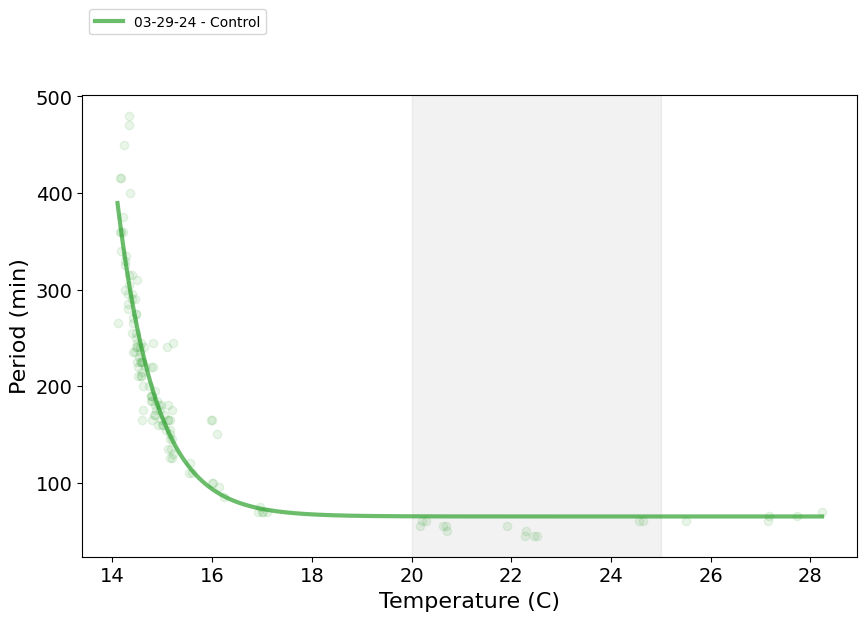

Processing 08-09-24


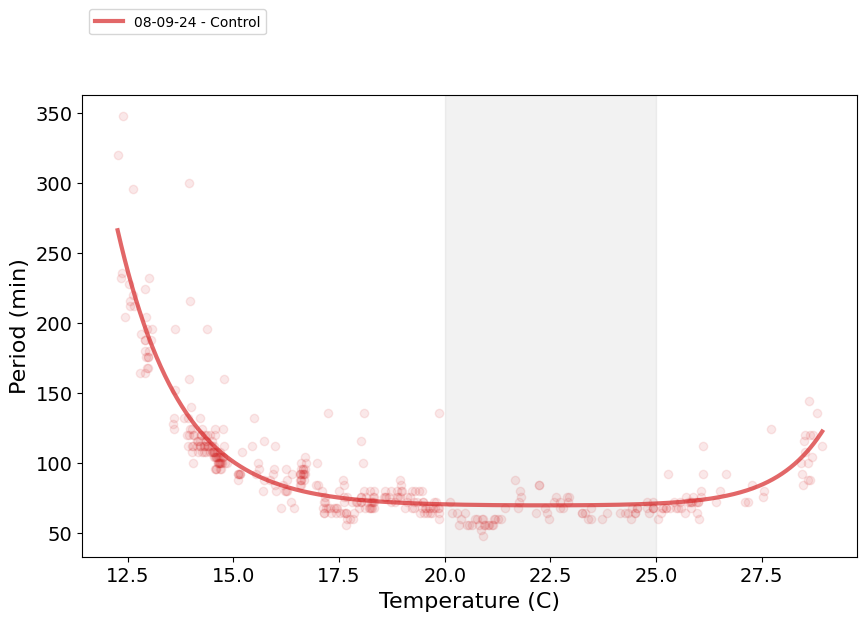

Processing 08-23-24


C:\Users\tavel\AppData\Local\Temp\ipykernel_19780\3246042356.py:2: RuntimeWarning: overflow encountered in exp
  rising_exp = a * np.exp(b * (x - c))


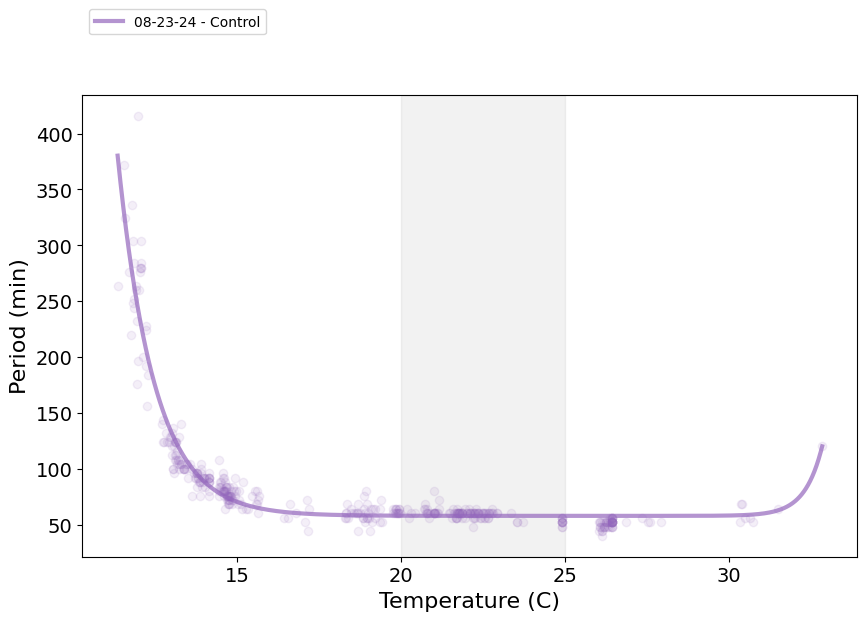

Processing 08-16-24


C:\Users\tavel\AppData\Local\Temp\ipykernel_19780\3246042356.py:3: RuntimeWarning: overflow encountered in exp
  falling_exp = d * np.exp(-e * (x - f))


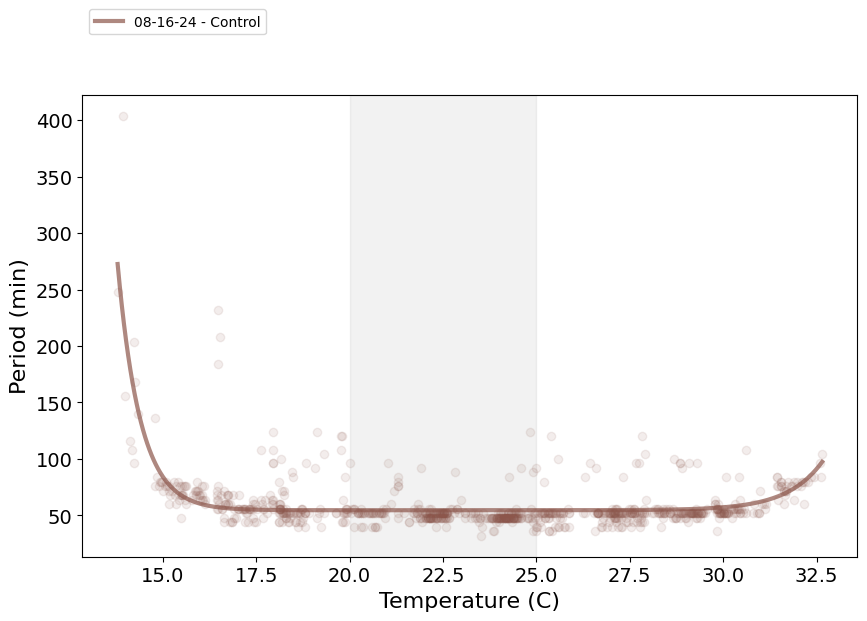

Processing 09-20-24


C:\Users\tavel\AppData\Local\Temp\ipykernel_19780\3246042356.py:2: RuntimeWarning: overflow encountered in exp
  rising_exp = a * np.exp(b * (x - c))
C:\Users\tavel\AppData\Local\Temp\ipykernel_19780\3246042356.py:3: RuntimeWarning: overflow encountered in exp
  falling_exp = d * np.exp(-e * (x - f))


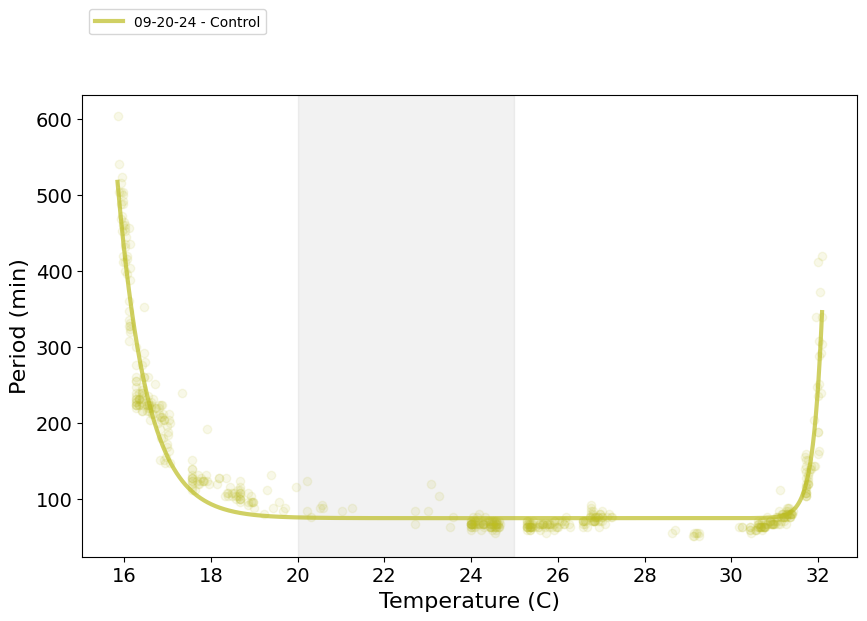

In [13]:
# Individual fits
label_fontsize = 16
ticks_fontsize = 14
cmap = plt.get_cmap('tab10')

for idx, date in enumerate(dates):
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    print(f"Processing {date}")
    period_file_location = os.path.join(data_location, date, f"{date}_full_periods.csv")
    full_periods = pd.read_csv(period_file_location)
    position_selection = (full_periods["POSITION"] >= positions[idx][0]) & \
                         (full_periods["POSITION"] <= positions[idx][1])
    cycle_selection = (full_periods[f"{cycle_calculation[idx]}_CYCLE_NUMBER"] == cycle_to_plot[idx])
    control_periods = full_periods[position_selection & cycle_selection]
    condition = conditions[idx]
    x = control_periods["MEAN_TEMPERATURE"].values
    y = control_periods[f"{cycle_calculation[idx]}_PERIOD"].values

    # Since I haven't fully curated 08-16-24 yet, I'll remove outliers manually here
    if date == "08-16-24":
        temp_range = (x > 17.0)
        period_range = (y > 125.0)
        selection = temp_range & period_range
        x = x[~selection]
        y = y[~selection]


    xfit, yfit, _ = fit_period_curve(x, y, pguess[idx])
    color = colors[idx]
    line_style = line_styles[idx]
    ax.plot(x, y, linestyle='None', marker='o', alpha=.1, color=color)
    ax.plot(xfit, yfit, color=color, label=f"{date} - {condition}", linewidth=3, alpha=.7,
            linestyle=line_style)

    ax.axvspan(xenopus_preferred_temp_range[0], 
            xenopus_preferred_temp_range[1], color="gray", alpha=.1)
    plt.legend(bbox_to_anchor=(0.0, 1.2), loc='upper left', ncols=4)
    plt.xlabel("Temperature (C)", fontsize=label_fontsize)
    plt.ylabel("Period (min)", fontsize=label_fontsize)
    plt.tick_params(axis='both', which='major', labelsize=ticks_fontsize)
    # add more yticks
    # plt.ylim(20, 500)
    # plt.yscale("log")
    plt.show()

# All together

Processing 10-28-22
Processing 11-04-22
Processing 03-29-24
Processing 08-09-24
Processing 08-23-24
Processing 08-16-24
Processing 09-20-24


C:\Users\tavel\AppData\Local\Temp\ipykernel_19780\3246042356.py:3: RuntimeWarning: overflow encountered in exp
  falling_exp = d * np.exp(-e * (x - f))
C:\Users\tavel\AppData\Local\Temp\ipykernel_19780\3246042356.py:12: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(fitting_fn, x, y, p0=p_guess)
C:\Users\tavel\AppData\Local\Temp\ipykernel_19780\3246042356.py:2: RuntimeWarning: overflow encountered in exp
  rising_exp = a * np.exp(b * (x - c))
C:\Users\tavel\AppData\Local\Temp\ipykernel_19780\3246042356.py:3: RuntimeWarning: overflow encountered in exp
  falling_exp = d * np.exp(-e * (x - f))
C:\Users\tavel\AppData\Local\Temp\ipykernel_19780\3246042356.py:2: RuntimeWarning: overflow encountered in exp
  rising_exp = a * np.exp(b * (x - c))
C:\Users\tavel\AppData\Local\Temp\ipykernel_19780\3246042356.py:3: RuntimeWarning: overflow encountered in exp
  falling_exp = d * np.exp(-e * (x - f))


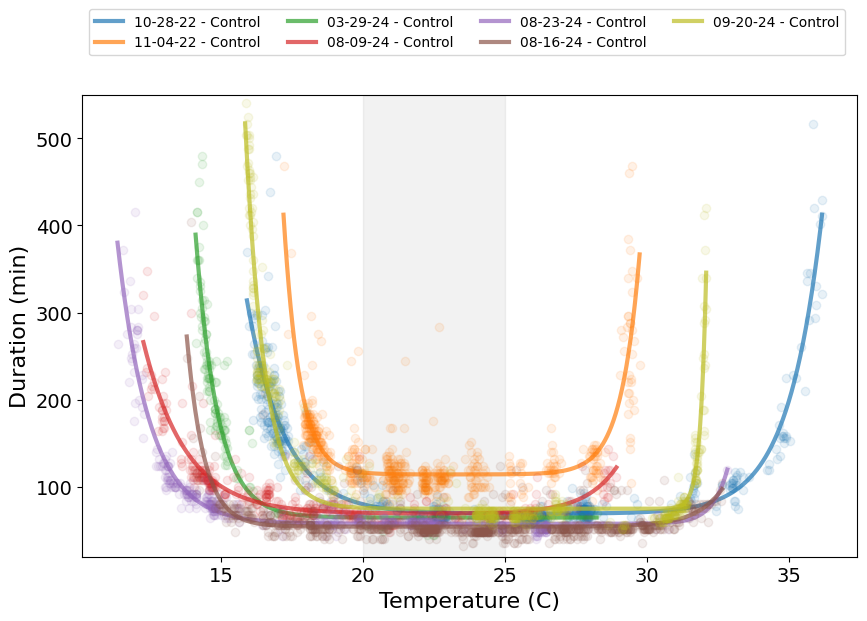

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
label_fontsize = 16
ticks_fontsize = 14
cmap = plt.get_cmap('tab10')

for idx, date in enumerate(dates):
    print(f"Processing {date}")
    period_file_location = os.path.join(data_location, date, f"{date}_full_periods.csv")
    full_periods = pd.read_csv(period_file_location)
    position_selection = (full_periods["POSITION"] >= positions[idx][0]) & \
                         (full_periods["POSITION"] <= positions[idx][1])
    cycle_selection = (full_periods[f"{cycle_calculation[idx]}_CYCLE_NUMBER"] == cycle_to_plot[idx])
    control_periods = full_periods[position_selection & cycle_selection]
    condition = conditions[idx]
    x = control_periods["MEAN_TEMPERATURE"].values
    y = control_periods[f"{cycle_calculation[idx]}_PERIOD"].values

    # Since I haven't fully curated 08-16-24 yet, I'll remove outliers manually here
    if date == "08-16-24":
        temp_range = (x > 17.0)
        period_range = (y > 125.0)
        selection = temp_range & period_range
        x = x[~selection]
        y = y[~selection]

    xfit, yfit, _ = fit_period_curve(x, y, pguess[idx])
    color = colors[idx]
    line_style = line_styles[idx]
    ax.plot(x, y, linestyle='None', marker='o', alpha=.1, color=color)
    ax.plot(xfit, yfit, color=color, label=f"{date} - {condition}", linewidth=3, alpha=.7,
            linestyle=line_style)

ax.axvspan(xenopus_preferred_temp_range[0], 
           xenopus_preferred_temp_range[1], color="gray", alpha=.1)
plt.legend(bbox_to_anchor=(0.0, 1.2), loc='upper left', ncols=4)
plt.xlabel("Temperature (C)", fontsize=label_fontsize)
plt.ylabel("Duration (min)", fontsize=label_fontsize)
plt.tick_params(axis='both', which='major', labelsize=ticks_fontsize)
# add more yticks
plt.ylim(20, 550)
# plt.yscale("log")
plt.show()

# For paper

Processing 10-28-22
Processing 11-04-22
Processing 03-29-24
Processing 08-09-24
Processing 08-23-24
Processing 08-16-24
Processing 09-20-24


C:\Users\tavel\AppData\Local\Temp\ipykernel_19780\3246042356.py:3: RuntimeWarning: overflow encountered in exp
  falling_exp = d * np.exp(-e * (x - f))
C:\Users\tavel\AppData\Local\Temp\ipykernel_19780\3246042356.py:12: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(fitting_fn, x, y, p0=p_guess)
C:\Users\tavel\AppData\Local\Temp\ipykernel_19780\3246042356.py:2: RuntimeWarning: overflow encountered in exp
  rising_exp = a * np.exp(b * (x - c))
C:\Users\tavel\AppData\Local\Temp\ipykernel_19780\3246042356.py:3: RuntimeWarning: overflow encountered in exp
  falling_exp = d * np.exp(-e * (x - f))
C:\Users\tavel\AppData\Local\Temp\ipykernel_19780\3246042356.py:2: RuntimeWarning: overflow encountered in exp
  rising_exp = a * np.exp(b * (x - c))
C:\Users\tavel\AppData\Local\Temp\ipykernel_19780\3246042356.py:3: RuntimeWarning: overflow encountered in exp
  falling_exp = d * np.exp(-e * (x - f))


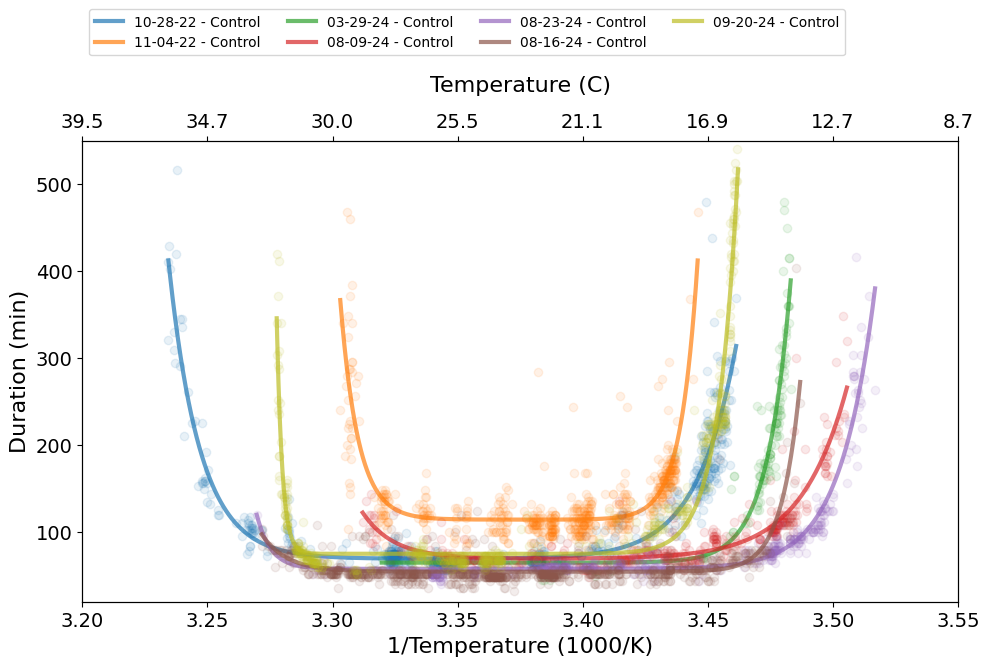

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
label_fontsize = 16
ticks_fontsize = 14
cmap = plt.get_cmap('tab10')

for idx, date in enumerate(dates):
    print(f"Processing {date}")
    period_file_location = os.path.join(data_location, date, f"{date}_full_periods.csv")
    full_periods = pd.read_csv(period_file_location)
    position_selection = (full_periods["POSITION"] >= positions[idx][0]) & \
                         (full_periods["POSITION"] <= positions[idx][1])
    cycle_selection = (full_periods[f"{cycle_calculation[idx]}_CYCLE_NUMBER"] == cycle_to_plot[idx])
    control_periods = full_periods[position_selection & cycle_selection]
    condition = conditions[idx]
    x = control_periods["MEAN_TEMPERATURE"].values
    y = control_periods[f"{cycle_calculation[idx]}_PERIOD"].values

    # Since I haven't fully curated 08-16-24 yet, I'll remove outliers manually here
    if date == "08-16-24":
        temp_range = (x > 17.0)
        period_range = (y > 125.0)
        selection = temp_range & period_range
        x = x[~selection]
        y = y[~selection]

    xfit, yfit, _ = fit_period_curve(x, y, pguess[idx])
    color = colors[idx]
    line_style = line_styles[idx]
    # ax.plot(x, y, linestyle='None', marker='o', alpha=.1, color=color)
    # ax.plot(xfit, yfit, color=color, label=f"{date} - {condition}", linewidth=3, alpha=.7,
    #         linestyle=line_style)
    new_x = 1000 / (x + 273.0)
    ax.plot(new_x, y, linestyle='None', marker='o', alpha=.1, color=color)
    new_xfit = 1000 / (xfit + 273.0)
    ax.plot(new_xfit, yfit, color=color, label=f"{date} - {condition}", linewidth=3, alpha=.7,
            linestyle=line_style)

plt.legend(bbox_to_anchor=(0.0, 1.3), loc='upper left', ncols=4)
plt.xlabel("1/Temperature (1000/K)", fontsize=label_fontsize)
plt.ylabel("Duration (min)", fontsize=label_fontsize)
plt.tick_params(axis='both', which='major', labelsize=ticks_fontsize)
ax.set_xlim(3.2, 3.55)
# add x-ticks for temperature at the top
# twin ax
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
new_tick_locations = ax.get_xticks()
new_tick_labels = 1000 / new_tick_locations - 273.0
new_tick_labels = [f"{temp:.1f}" for temp in new_tick_labels]
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(new_tick_labels, fontsize=ticks_fontsize)
ax2.set_xlabel("Temperature (C)", fontsize=label_fontsize, labelpad=15)
plt.ylim(20, 550)
plt.tight_layout()
plt.savefig("E:/Project 6 - Temperature/Experiments/data_analysis/all_controls.pdf")
plt.show()

In [23]:
print(new_tick_locations)
print(new_tick_labels)

[3.2  3.25 3.3  3.35 3.4  3.45 3.5  3.55]
[39.5        34.69230769 30.03030303 25.50746269 21.11764706 16.85507246
 12.71428571  8.69014085]


Processing 10-28-22
Processing 11-04-22
Processing 03-29-24
Processing 08-09-24
Processing 08-23-24
Processing 08-16-24
Processing 03-29-24
Processing 08-09-24
Processing 08-23-24


C:\Users\tavel\AppData\Local\Temp\ipykernel_16636\3246042356.py:3: RuntimeWarning: overflow encountered in exp
  falling_exp = d * np.exp(-e * (x - f))
C:\Users\tavel\AppData\Local\Temp\ipykernel_16636\3246042356.py:12: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(fitting_fn, x, y, p0=p_guess)
C:\Users\tavel\AppData\Local\Temp\ipykernel_16636\3246042356.py:2: RuntimeWarning: overflow encountered in exp
  rising_exp = a * np.exp(b * (x - c))
C:\Users\tavel\AppData\Local\Temp\ipykernel_16636\3246042356.py:3: RuntimeWarning: overflow encountered in exp
  falling_exp = d * np.exp(-e * (x - f))
C:\Users\tavel\AppData\Local\Temp\ipykernel_16636\3246042356.py:2: RuntimeWarning: overflow encountered in exp
  rising_exp = a * np.exp(b * (x - c))
C:\Users\tavel\AppData\Local\Temp\ipykernel_16636\3246042356.py:12: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(fitting_fn, x, y, p0=p_guess)
C:\Users\tav

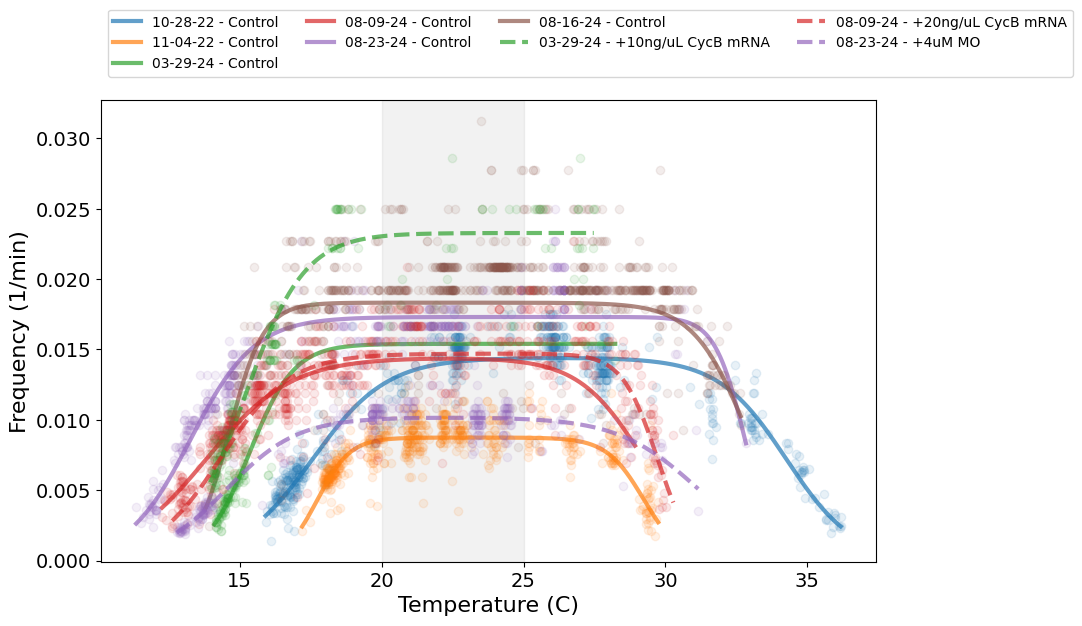

In [84]:
# Same plot as before but with frequecy
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
label_fontsize = 16
ticks_fontsize = 14
cmap = plt.get_cmap('tab10')

for idx, date in enumerate(dates):
    print(f"Processing {date}")
    period_file_location = os.path.join(data_location, date, f"{date}_full_periods.csv")
    full_periods = pd.read_csv(period_file_location)
    position_selection = (full_periods["POSITION"] >= positions[idx][0]) & \
                         (full_periods["POSITION"] <= positions[idx][1])
    cycle_selection = (full_periods[f"{cycle_calculation[idx]}_CYCLE_NUMBER"] == cycle_to_plot[idx])
    control_periods = full_periods[position_selection & cycle_selection]
    x = control_periods["MEAN_TEMPERATURE"].values
    y = control_periods[f"{cycle_calculation[idx]}_PERIOD"].values
    condition = conditions[idx]

    # Since I haven't fully curated 08-16-24 yet, I'll remove outliers manually here
    if date == "08-16-24":
        temp_range = (x > 17.0)
        period_range = (y > 125.0)
        selection = temp_range & period_range
        x = x[~selection]
        y = y[~selection]

    xfit, yfit, _ = fit_period_curve(x, y, pguess[idx])
    color = colors[idx]
    line_style = line_styles[idx]
    ax.plot(x, 1.0/y, linestyle='None', marker='o', alpha=.1, color=color)
    ax.plot(xfit, 1.0/yfit, color=color, label=f"{date} - {condition}", linewidth=3, alpha=.7,
            linestyle=line_style)


ax.axvspan(xenopus_preferred_temp_range[0], 
           xenopus_preferred_temp_range[1], color="gray", alpha=.1)
plt.legend(bbox_to_anchor=(0.0, 1.21), loc='upper left', ncols=4)
plt.xlabel("Temperature (C)", fontsize=label_fontsize)
plt.ylabel("Frequency (1/min)", fontsize=label_fontsize)
plt.tick_params(axis='both', which='major', labelsize=ticks_fontsize)
# add more yticks
# plt.ylim(20, 500)
# plt.yscale("log")
plt.show()

# Curve correlation

In [23]:
def get_percent_change_thresholds(temperature, period, percent_change=0.1):
    period_min = period.min()
    period_threshold = period_min * (1.0 + percent_change)
    # find temperatures where period crosses the threshold
    temperature_thresholds = temperature[period <= period_threshold]
    temperature_threshold_max = temperature_thresholds.max()
    temperature_threshold_min = temperature_thresholds.min()
    return temperature_threshold_min, temperature_threshold_max

Processing 10-28-22
10-28-22: 20.56 - 31.53
Processing 11-04-22
11-04-22: 19.07 - 27.71
Processing 03-29-24
03-29-24: 17.16 - 28.23
Processing 08-09-24
08-09-24: 17.18 - 26.68
Processing 08-23-24
08-23-24: 15.87 - 31.57
Processing 08-16-24
08-16-24: 16.04 - 30.69
Processing 03-29-24


C:\Users\tavel\AppData\Local\Temp\ipykernel_16636\3246042356.py:3: RuntimeWarning: overflow encountered in exp
  falling_exp = d * np.exp(-e * (x - f))
C:\Users\tavel\AppData\Local\Temp\ipykernel_16636\3246042356.py:12: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(fitting_fn, x, y, p0=p_guess)
C:\Users\tavel\AppData\Local\Temp\ipykernel_16636\3246042356.py:2: RuntimeWarning: overflow encountered in exp
  rising_exp = a * np.exp(b * (x - c))
C:\Users\tavel\AppData\Local\Temp\ipykernel_16636\3246042356.py:3: RuntimeWarning: overflow encountered in exp
  falling_exp = d * np.exp(-e * (x - f))
C:\Users\tavel\AppData\Local\Temp\ipykernel_16636\3246042356.py:2: RuntimeWarning: overflow encountered in exp
  rising_exp = a * np.exp(b * (x - c))
C:\Users\tavel\AppData\Local\Temp\ipykernel_16636\3246042356.py:12: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(fitting_fn, x, y, p0=p_guess)
C:\Users\tav

03-29-24: 17.60 - 27.47
Processing 08-09-24
08-09-24: 17.13 - 28.28
Processing 08-23-24
08-23-24: 17.38 - 27.94


C:\Users\tavel\AppData\Local\Temp\ipykernel_16636\3246042356.py:2: RuntimeWarning: overflow encountered in exp
  rising_exp = a * np.exp(b * (x - c))


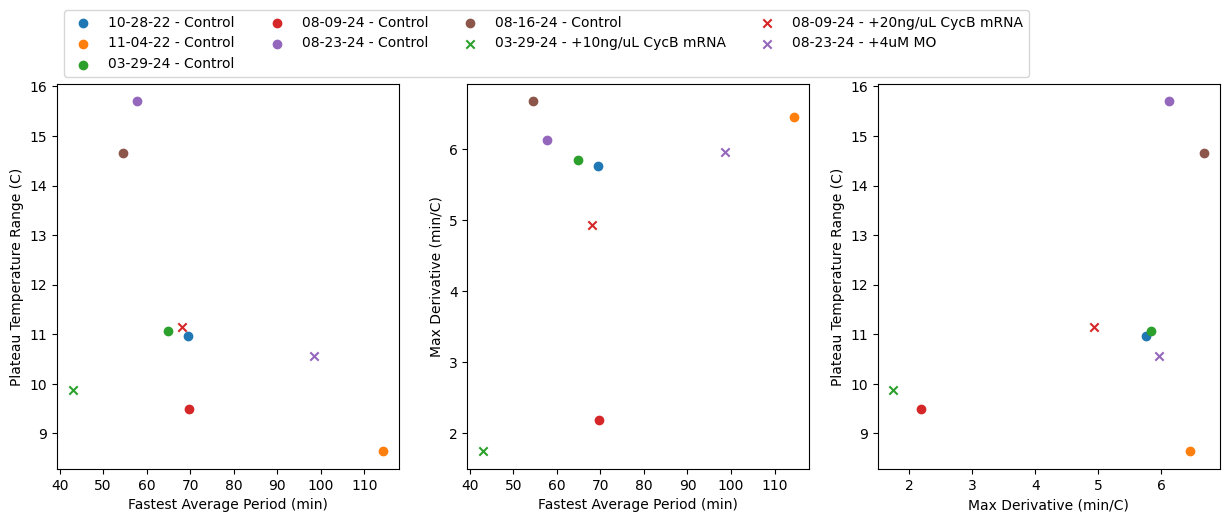

In [85]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for idx, date in enumerate(dates):
    print(f"Processing {date}")
    period_file_location = os.path.join(data_location, date, f"{date}_full_periods.csv")
    full_periods = pd.read_csv(period_file_location)
    position_selection = (full_periods["POSITION"] >= positions[idx][0]) & \
                         (full_periods["POSITION"] <= positions[idx][1])
    cycle_selection = (full_periods[f"{cycle_calculation[idx]}_CYCLE_NUMBER"] == cycle_to_plot[idx])
    control_periods = full_periods[position_selection & cycle_selection]
    condition = conditions[idx]
    x = control_periods["MEAN_TEMPERATURE"].values
    y = control_periods[f"{cycle_calculation[idx]}_PERIOD"].values

    # Since I haven't fully curated 08-16-24 yet, I'll remove outliers manually here
    if date == "08-16-24":
        temp_range = (x > 17.0)
        period_range = (y > 125.0)
        selection = temp_range & period_range
        x = x[~selection]
        y = y[~selection]

    xfit, yfit, _ = fit_period_curve(x, y, pguess[idx])

    tmin, tmax = get_percent_change_thresholds(xfit, yfit)
    dtemp = tmax - tmin
    period_min = yfit.min()
    max_derivative = np.abs(np.diff(yfit)).max()
    color = colors[idx]
    marker_style = marker_styles[idx]
    axs[0].scatter(period_min, dtemp, label=f"{date} - {condition}", color=color, marker=marker_style)
    axs[1].scatter(period_min, max_derivative, color=color, marker=marker_style)
    axs[2].scatter(max_derivative, dtemp, color=color, marker=marker_style)

    print(f"{date}: {tmin:.2f} - {tmax:.2f}")

axs[0].set_xlabel("Fastest Average Period (min)")
axs[1].set_xlabel("Fastest Average Period (min)")
axs[2].set_xlabel("Max Derivative (min/C)")
axs[0].set_ylabel("Plateau Temperature Range (C)")
axs[1].set_ylabel("Max Derivative (min/C)")
axs[2].set_ylabel("Plateau Temperature Range (C)")

axs[0].legend(bbox_to_anchor=(0.0, 1.21), loc='upper left', ncols=4)
plt.show()
